# Trend in bonds investment:

## Data processing

In [2]:
from PIL import Image
import requests
from io import BytesIO
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image

from datetime import datetime, timedelta
import statsmodels.api as sm
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [3]:
bonds = pd.read_csv("https://www.dropbox.com/s/70ig02z77ranw6x/All_of_the_data.csv?dl=1",header=0)
bonds.head(n=3)

,NCB,historical_date,ISIN_Code,Issuer_Name,Maturity_Date,Coupon_Rate,company_name,company_description,relationship_to_bond,sector,...,status,stocks_info,bond_types,Floating rate,Foreign bonds,Green bonds,Securitization,Senior Secured,Senior Unsecured,Zero-coupon bonds
0,FI,20170811,AT0000A0KSM6,NOVOMATIC AG,27/10/2017,5,Novomatic,The NOVOMATIC Holding is an integrated global ...,Profile,corporate,...,Matured,"Par amount, integral multiple",NaN,no,no,no,no,no,no,no
1,FI,20171013,AT0000A0KSM6,NOVOMATIC AG,10/27/2017,5,Novomatic,The NOVOMATIC Holding is an integrated global ...,Profile,corporate,...,Matured,"Par amount, integral multiple",NaN,no,no,no,no,no,no,no
2,FI,20170721,AT0000A0KSM6,NOVOMATIC AG,27/10/2017,5,Novomatic,The NOVOMATIC Holding is an integrated global ...,Profile,corporate,...,Matured,"Par amount, integral multiple",NaN,no,no,no,no,no,no,no


In [5]:
bonds.dtypes

NCB                     object
historical_date          int64
ISIN_Code               object
Issuer_Name             object
Maturity_Date           object
Coupon_Rate             object
company_name            object
company_description     object
relationship_to_bond    object
sector                  object
industry                object
bond_destination        object
coupon_rate             object
total_bond_amount       object
nominal_amount          object
quarter_created         object
year_created             int64
maturity_date           object
bond_currency           object
country                 object
status                  object
stocks_info             object
bond_types              object
Floating rate           object
Foreign bonds           object
Green bonds             object
Securitization          object
Senior Secured          object
Senior Unsecured        object
Zero-coupon bonds       object
dtype: object

In [6]:
##Subsetting columns
bonds=bonds[["industry","country","bond_types","ISIN_Code","total_bond_amount","coupon_rate","nominal_amount","maturity_date",'historical_date']]
bonds.shape

(256413, 9)

In [7]:
#Deletion of null bond types
bonds=bonds[~pd.isnull(bonds["bond_types"])]
bonds.shape

(141483, 9)

In [8]:
#Grouping bond types
auxgreen=["Green" in  aux for aux in bonds["bond_types"]]
bonds.iloc[auxgreen,2]="Green bonds"

auxzero=["Zero" in  aux for aux in bonds["bond_types"]]
bonds.iloc[auxzero,2]="Zero-coupon bonds"

auxforeign=["Foreign" in  aux for aux in bonds["bond_types"]]
bonds.iloc[auxforeign,2]="Foreign bonds"

auxfloating=["Floating" in  aux for aux in bonds["bond_types"]]
bonds.iloc[auxfloating,2]="Floating rate"

bonds["bond_types"][bonds["bond_types"].isin(["Senior Secured", "Floating rate", "Foreign bonds","Securitization"])]="Others"


In [9]:
bonds["bond_types"].value_counts()

Senior Unsecured     117384
Green bonds           11484
Others                 6793
Zero-coupon bonds      5822
Name: bond_types, dtype: int64

In [10]:
#Groupipng industries
bonds["industry"][bonds["industry"].isin(["Pulp, paper and wood industries", "Ferrous metals", "Mining industry","Non-ferrous metals"])]="Other sectors"
bonds["industry"].value_counts()

Power                                  23281
Engineering industry                   15149
Communication                          13960
Oil and gas                            13757
Financial institutions                 12832
Construction and development           12725
Chemical and petrochemical industry    10798
Transportation                         10264
Food industry                           6565
Public utilities                        5384
Healthсare                              5166
Information and High Technologies       4026
Other sectors                           3042
Trade and retail                        1565
Light industry                          1525
Media and Entertainment                 1444
Name: industry, dtype: int64

In [11]:
#Convert integer to date format
bonds['historical_date'] = pd.to_datetime(bonds['historical_date'], format='%Y%m%d')
bonds.sort_values(by=['historical_date'], inplace=True)


bonds['week']=bonds['historical_date'].dt.week.astype(int)
bonds['year']=bonds['historical_date'].dt.year.astype(int)

In [12]:
#Assigning a week number to each obs
bonds['extra_weeks_2017'] = np.where(bonds['year']==2017, -25, 0)
bonds['extra_weeks_2018'] = np.where(bonds['year']>=2018, 27, 0)
bonds['extra_weeks_2019'] = np.where(bonds['year']>=2019, 52, 0)
bonds['extra_weeks_2020'] = np.where(bonds['year']>=2020, 52, 0)
bonds['extra_weeks_2021'] = np.where(bonds['year']>=2021, 51, 0)


sum_column = bonds['week']+ bonds['extra_weeks_2017']+ bonds['extra_weeks_2018']+ bonds['extra_weeks_2019']+ bonds['extra_weeks_2020']+ bonds['extra_weeks_2021']
bonds["n_week"] = sum_column

In [13]:
##Transform nominal_amount into int
bonds[['amount_str', 'EUR']] = bonds['nominal_amount'].str.split(' ', 1, expand=True)
bonds['nom_amount']=bonds['amount_str'].str.replace(',','')
bonds['nom_amount']=bonds['nom_amount'].astype(int)

## Investment by bond type

In [14]:
##Total investment by week and bond type
cum_bonds=bonds.groupby(['n_week','bond_types'], as_index=False).agg(total_invest=('nom_amount', sum))
cum_bonds.T

,0,1,2,3,4,5,6,7,8,9,...,794,795,796,797,798,799,800,801,802,803
n_week,0,0,0,0,1,1,1,1,2,2,...,198,198,199,199,199,199,200,200,200,200
bond_types,Green bonds,Others,Senior Unsecured,Zero-coupon bonds,Green bonds,Others,Senior Unsecured,Zero-coupon bonds,Green bonds,Others,...,Senior Unsecured,Zero-coupon bonds,Green bonds,Others,Senior Unsecured,Zero-coupon bonds,Green bonds,Others,Senior Unsecured,Zero-coupon bonds
total_invest,1508000,1006000,9329153,712000,1510000,1106000,9329153,712000,1510000,1206000,...,25456304,2636000,4567200,3216000,25561304,2637000,4567200,3216000,25563304,2638000


In [15]:
#Total investment per week
sum_week=cum_bonds.groupby('n_week', as_index=False).sum()
sum_week.T


,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,200
n_week,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,200
total_invest,12555153,12657153,12760153,12761153,12861153,12961153,13065153,13165153,13165153,13165153,...,35254504,35361504,35363504,35462504,35468504,35872504,36074504,35975504,35981504,35984504


In [16]:
total_per_week=[]
for i in range(0, 201, 1):
    repeated=  itertools.repeat(sum_week['total_invest'][i], 4)
    total_per_week.extend(repeated)
cum_bonds['weekly_total']=total_per_week
#Percentage of weekly total invest
cum_bonds['week_percent']=cum_bonds['total_invest']/cum_bonds['weekly_total']

In [17]:
#Curves per bond type
others=cum_bonds[cum_bonds['bond_types']=='Others']
green=cum_bonds[cum_bonds['bond_types']=='Green bonds']
unsecured=cum_bonds[cum_bonds['bond_types']=='Senior Unsecured']
zero=cum_bonds[cum_bonds['bond_types']=='Zero-coupon bonds']

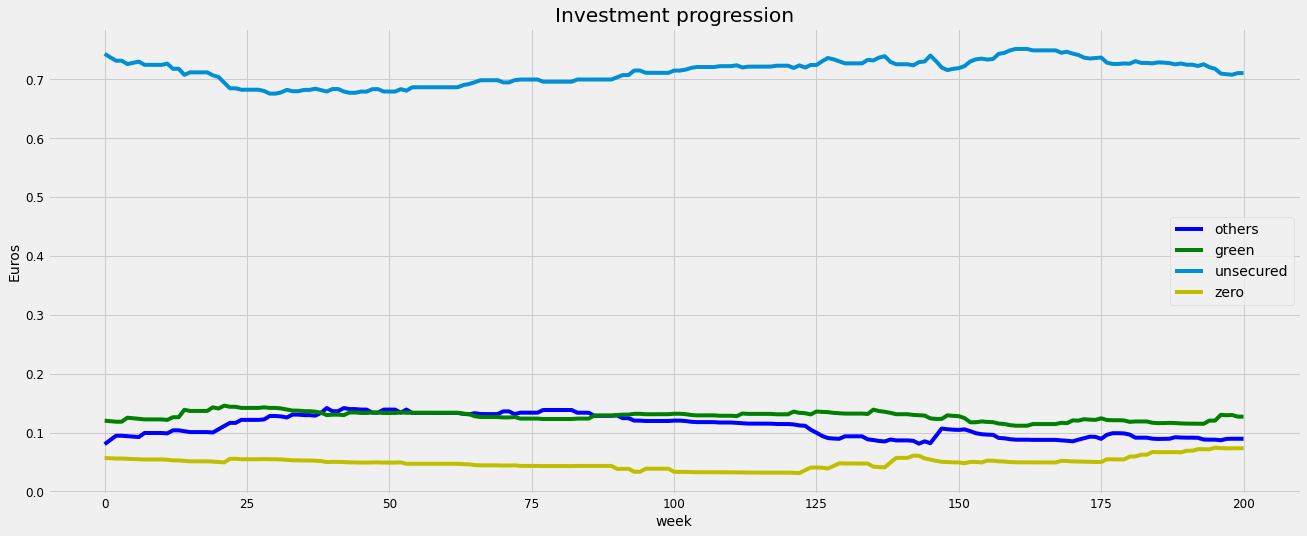

In [18]:
inv_plot1, ax=plt.subplots(figsize=(20, 8))
plt.plot(others['n_week'], others['week_percent'], 'b-', label = 'others')
plt.plot(green['n_week'], green['week_percent'], 'g-', label = 'green')
plt.plot(unsecured['n_week'], unsecured['week_percent'], '-', label = 'unsecured')
plt.plot(zero['n_week'], zero['week_percent'], 'y-', label = 'zero')
plt.xlabel('week'); plt.ylabel('Euros'); plt.title('Investment progression')
plt.legend();
plt.savefig('inv_plot.png')
plt.show()


In [21]:
#plot saved image
response = requests.get('https://github.com/Dansieg91/ECB-Bond-Purchases/raw/main/Plots/Cor_An.png')
inv_prog = Image.open(BytesIO(response.content))

In [ ]:
##Total investment by week and bond type
cum_industry=bonds.groupby(['n_week','industry'], as_index=False).agg(total_invest=('nom_amount', sum))

In [ ]:
#Total investment per week
sum_week_industry=cum_industry.groupby('n_week', as_index=False).sum()
cum_industry.T

In [ ]:
total_per_week=[]
for i in range(0, 201, 1):
    repeated=  itertools.repeat(sum_week_industry['total_invest'][i], 16)
    total_per_week.extend(repeated)
cum_industry['weekly_total']=total_per_week
#Percentage of weekly total invest
cum_industry['week_percent']=cum_industry['total_invest']/cum_industry['weekly_total']

## Investment by industry

In [ ]:
chemical_petrochemical_industry=cum_industry[cum_industry['industry']=='Chemical and petrochemical industry']                                   
Construction_development=cum_industry[cum_industry['industry']=='Construction and development']                                    
Food_industry =cum_industry[cum_industry['industry']=='Food industry']                                     
Oil_gas=cum_industry[cum_industry['industry']=='Oil and gas']                                   
Engineering_industry=cum_industry[cum_industry['industry']=='Engineering industry']                                    
Information_High_Technologies=cum_industry[cum_industry['industry']=='Information and High Technologies']                                    
Power =cum_industry[cum_industry['industry']=='Power']                                     
Media_Entertainment =cum_industry[cum_industry['industry']=='Media and Entertainment']                                    
Communication=cum_industry[cum_industry['industry']=='Communication']                                    
Public_utilities =cum_industry[cum_industry['industry']=='Public utilities']                                     
Financial_institutions =cum_industry[cum_industry['industry']=='Financial institutions']                                     
Transportation=cum_industry[cum_industry['industry']=='Transportation']                                    
Other_sectors =cum_industry[cum_industry['industry']=='Other sectors']                                     
Healthсare =cum_industry[cum_industry['industry']=='Healthсare']                                     
Light_industry=cum_industry[cum_industry['industry']=='Light industry']                                  
Trade_retail=cum_industry[cum_industry['industry']=='Trade and retail']  

In [ ]:
plt.figure(figsize=(20, 8))

plt.plot(chemical_petrochemical_industry['n_week'],chemical_petrochemical_industry['week_percent'], 'd-', label = 'chemical_petrochemical_industry')                       
plt.plot(Construction_development['n_week'],Construction_development['week_percent'], 'b-', label = 'Construction_development')          
plt.plot(Food_industry['n_week'],Food_industry['week_percent'], 'c-', label = 'Food_industry')
plt.plot(Oil_gas['n_week'],Oil_gas['week_percent'],'d-', label = 'Oil_gas')          
plt.plot(Engineering_industry['n_week'],Engineering_industry['week_percent'], 'y-', label = 'Engineering_industry')                                                          
plt.plot(Information_High_Technologies['n_week'],Information_High_Technologies['week_percent'], 'g-', label = 'Information_High_Technologies')                                          
plt.plot(Power['n_week'],Power['week_percent'], 'r-', label = 'Power')                          
plt.plot(Media_Entertainment['n_week'],Media_Entertainment['week_percent'], 'h-', label = 'Media_Entertainment')                                                               
plt.plot(Communication['n_week'],Communication['week_percent'], 'p-', label = 'Communication')                                         
plt.plot(Public_utilities['n_week'],Public_utilities['week_percent'], 'r-', label = 'Public_utilities')                                                            
plt.plot(Financial_institutions['n_week'],Financial_institutions['week_percent'], 'p-', label = 'Financial_institutions')                                         
plt.plot(Transportation['n_week'],Transportation['week_percent'], 'w-', label = 'Transportation')                                                          
plt.plot(Other_sectors['n_week'],Other_sectors['week_percent'], 'm-', label = 'Other_sectors')                                                            
plt.plot(Healthсare['n_week'],Healthсare['week_percent'], 'h-', label = 'Healthсare')                                                            
plt.plot(Light_industry['n_week'],Light_industry['week_percent'], 'o-', label = 'Light_industry')                                                        
plt.plot(Trade_retail['n_week'],Trade_retail['week_percent'], 'p-', label = 'Trade_retail') 

plt.xlabel('week'); plt.ylabel('Euros'); plt.title('Investment progression')

plt.legend();
plt.savefig('inv_plot_ind.png')

In [ ]:
#plot saved image
response = requests.get('https://github.com/Dansieg91/ECB-Bond-Purchases/raw/main/Plots/inv_plot_ind.png')
inv_prog_ind = Image.open(BytesIO(response.content))